In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from yaml import safe_load, YAMLError
from src.snapshots import snapshots_assembly
from src.dim_reduction import SVD, AutoEncoder

2024-01-12 12:35:45,374 - matplotlib - DEBUG - matplotlib data path: /home/bombra/anaconda3/envs/padme/lib/python3.11/site-packages/matplotlib/mpl-data
2024-01-12 12:35:45,380 - matplotlib - DEBUG - CONFIGDIR=/home/bombra/.config/matplotlib
2024-01-12 12:35:45,383 - matplotlib - DEBUG - interactive is False
2024-01-12 12:35:45,384 - matplotlib - DEBUG - platform is linux
2024-01-12 12:35:45,436 - matplotlib - DEBUG - CACHEDIR=/home/bombra/.cache/matplotlib
2024-01-12 12:35:45,438 - matplotlib.font_manager - DEBUG - Using fontManager instance from /home/bombra/.cache/matplotlib/fontlist-v330.json


In [3]:
with open("parameters.yaml", "r") as stream:
    try:
        params = safe_load(stream)
    except YAMLError as exc:
        print(exc)

In [4]:
params

{'snapshots': {'file_type_str': 'h5_fenics',
  'folder': 'data/input',
  'file_name_contains': ['concentration'],
  'dataset': None},
 'svd': {'visualization_folder': 'data/visualization',
  'trunc_basis': 270,
  'svd_type': 'randomized_svd',
  'power_iterations': 1,
  'oversampling': 20},
 'auto_encoder': {'visualization_folder': 'data/visualization',
  'batch_size': 10,
  'num_epochs': 20,
  'learning_rate': '1e-4',
  'weight_decay': '1e-8',
  'loss_function': 'smooth_l1_loss',
  'loss_parameters': {'beta': 0.2},
  'num_workers': 2,
  'number_of_hidden_layers': 5,
  'hidden_layers_sizes': [256, 128, 64, 32, 16],
  'hidden_layers_activation_function': ['leaky_relu',
   'leaky_relu',
   'leaky_relu',
   'leaky_relu',
   ''],
  'hidden_layers_activation_function_parameters': [0.2, 0.2, 0.2, 0.2, 'None'],
  'decoder_activation_function': 'sigmoid',
  'decoder_activation_function_parameter': 'None'}}

In [5]:
try:
    print(snapshots.shape)
except:
    filenames, snapshots = snapshots_assembly(params["snapshots"])

2024-01-12 12:35:46,132 - src.snapshots - INFO - Starting choice of file type:
2024-01-12 12:35:46,133 - src.snapshots - INFO - FEniCS HDF5 file selected.
Loading Snapshots 2701: 100%|██████████| 2701/2701 [01:38<00:00, 27.33it/s]


2024-01-12 12:37:35,256 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-01-12 12:37:35,258 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


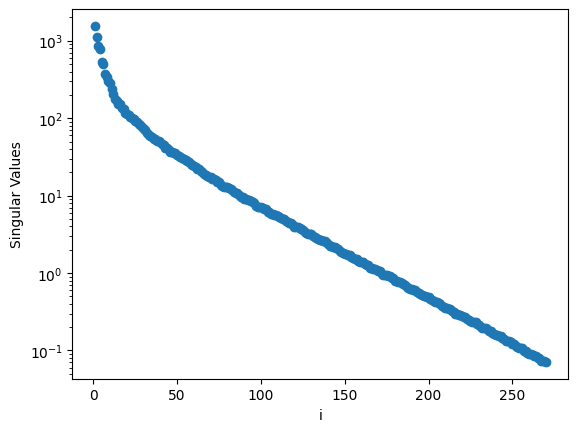

In [6]:
svd_step_randomized = SVD(snapshots, params["svd"])
svd_step_randomized.fit()
svd_step_randomized.plot_singular_values()

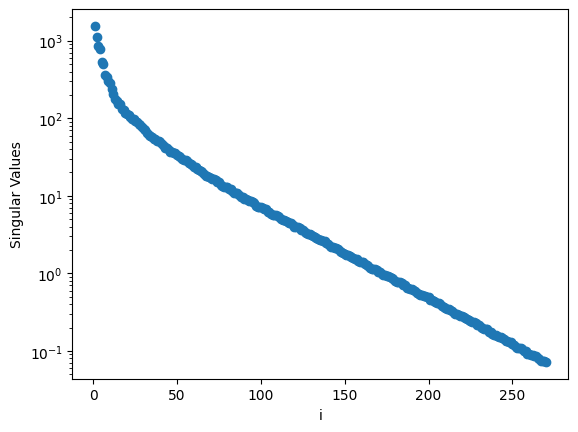

In [7]:
params["svd"]["svd_type"] = "full_svd"
svd_step_full = SVD(snapshots, params["svd"])
svd_step_full.fit()
svd_step_full.plot_singular_values()

In [8]:
import numpy as np

np.linalg.norm(svd_step_randomized.s - svd_step_full.s, 2) / np.linalg.norm(
    svd_step_full.s, 2
)

6.031638724948223e-07

In [15]:
ae_test_2 = AutoEncoder(svd_step_randomized.u.T, params["auto_encoder"])
ae_test_2.fit()

print(ae_test_2.auto_encoder.encoder)
print(ae_test_2.auto_encoder.decoder)

/home/bombra/anaconda3/envs/padme/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


<class 'torch.utils.data.dataloader.DataLoader'>


  5%|▌         | 1/20 [00:08<02:37,  8.29s/it]

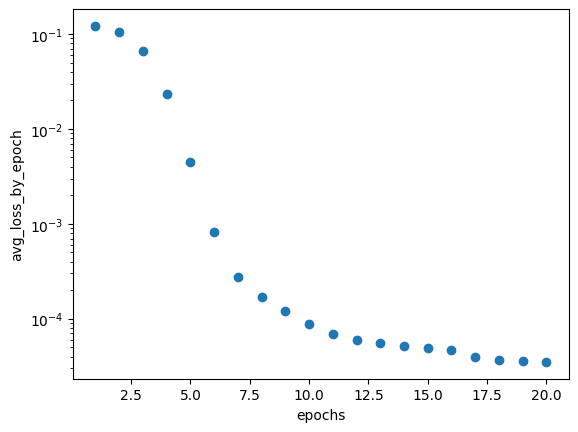

In [10]:
ae_test_2.plot_quantities_per_epoch("avg_loss_by_epoch")

In [13]:
u_original = svd_step_randomized.u.T[:, 0]
u_reconstructed = ae_test_2.auto_encoder.forward(ae_test_2.data[:, 0])

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
import numpy as np

np.linalg.norm(u_original - u_reconstructed) / np.linalg.norm(u_original, 2)

In [ ]:
ae_test_2.insert_h5_vector(u_reconstructed)